In [ ]:
# -*- coding: utf-8 -*-
"""Analisis Keterlambatan Kapal dengan IBM Granite.ipynb

Automatically generated by Colaboratory.
"""

# ======================
# 1. INSTALL & IMPORT LIBRARY
# ======================
!pip install replicate pandas matplotlib --quiet
import os
import re
import time
import replicate
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata  # Changed from auth to userdata

print("✅ Libraries installed successfully!")

# ======================
# 2. SETUP API TOKEN - FIXED VERSION
# ======================
try:
    # Get API token from Colab Secrets
    os.environ["buat_token"] = userdata.get('buat_token')
    print("✅ API token loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API token: {e}")
    print("\nPanduan menyimpan token:")
    print("1. Klik ikon 'kunci' di panel kiri Colab")
    print("2. Tambahkan secret baru dengan nama buat_token")
    print("3. Paste token Replicate Anda (format: r8_...)")
    print("4. Klik 'Add Notebook Access'")
    # Exit if no token found
    raise SystemExit("Script dihentikan karena token tidak valid")

# ======================
# 3. LOAD DATASET
# ======================
data = {
    "tanggal": ["2023-01-10", "2023-02-15", "2023-03-20", "2023-04-05"],
    "deskripsi": [
        "Kapal delay karena badai di Laut Jawa",
        "Kerusakan mesin menyebabkan keterlambatan 12 jam",
        "Pemeriksaan bea cukai memakan waktu 24 jam",
        "Keterlambatan bongkar muat di pelabuhan"
    ],
    "durasi_jam": [24, 12, 24, 8]
}
df = pd.DataFrame(data)

# Fungsi pembersih teks
def clean_text(text):
    text = str(text).lower()  # Pastikan string dan case folding
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    return text

df["deskripsi_bersih"] = df["deskripsi"].apply(clean_text)
print("\n📊 Contoh data setelah cleaning:")
print(df.head())

# ======================
# 4. KLASIFIKASI PENYEBAB - IMPROVED VERSION
# ======================
def klasifikasi_penyebab(teks):
    prompt = f"""
    Klasifikasikan penyebab keterlambatan kapal berikut ke dalam salah satu kategori:
    [Cuaca, Teknis, Logistik, Bea Cukai, Lainnya].
    Jawab HANYA dengan nama kategori.

    Deskripsi: {teks}
    """

    try:
        response = replicate.run(
            "ibm-granite/granite-3.0-8b-instruct",
            input={
                "prompt": prompt,
                "max_tokens": 10,
                "temperature": 0.3,
                "top_p": 0.9
            }
        )
        time.sleep(1)  # Delay untuk hindari rate limit

        # Handle different response formats
        if isinstance(response, list):
            return response[0].strip() if len(response) > 0 else "Lainnya"
        elif isinstance(response, str):
            return response.strip()
        else:
            return "Lainnya"

    except Exception as e:
        print(f"Error saat klasifikasi: {e}")
        return None

print("\n🔄 Sedang mengklasifikasikan data...")
df["prediksi_penyebab"] = df["deskripsi_bersih"].apply(klasifikasi_penyebab)

# ======================
# 5. SUMMARIZATION - IMPROVED VERSION
# ======================
def buat_ringkasan(daftar_teks):
    gabungan_teks = "\n- ".join(daftar_teks)
    prompt = f"""
    Buatlah ringkasan laporan keterlambatan kapal dalam 3 poin penting:
    - {gabungan_teks}

    Format:
    1. [Poin 1]
    2. [Poin 2]
    3. [Poin 3]
    """

    try:
        response = replicate.run(
            "ibm-granite/granite-3.0-8b-instruct",  # Fixed model name
            input={
                "prompt": prompt,
                "max_tokens": 150,
                "temperature": 0.5,
                "repetition_penalty": 1.2
            }
        )
        # Handle different response formats
        if isinstance(response, list):
            return "\n".join([str(item) for item in response])
        return str(response)
    except Exception as e:
        print(f"Error saat summarization: {e}")
        return "Tidak dapat membuat ringkasan"

print("\n📝 Membuat ringkasan...")
ringkasan = buat_ringkasan(df["deskripsi"].tolist())
print("\n🔍 HASIL RINGKASAN:")
print(ringkasan)

# ======================
# 6. VISUALISASI - IMPROVED VERSION
# ======================
if df["prediksi_penyebab"].notnull().any():
    print("\n📈 Visualisasi data...")

    # Create manual categories if all predictions are None
    if df["prediksi_penyebab"].isnull().all():
        kategori_manual = {
            "badai": "Cuaca",
            "mesin": "Teknis",
            "bea cukai": "Bea Cukai",
            "bongkar muat": "Logistik"
        }
        df["prediksi_penyebab"] = df["deskripsi"].apply(
            lambda x: next((v for k, v in kategori_manual.items() if k in x.lower()), "Lainnya")
        )

    plt.figure(figsize=(10,6))
    df["prediksi_penyebab"].value_counts().plot(
        kind='bar',
        color=['skyblue', 'salmon', 'lightgreen', 'gold'],
        edgecolor='black'
    )
    plt.title("Distribusi Penyebab Keterlambatan Kapal", pad=20, fontsize=14)
    plt.xlabel("Kategori Penyebab", labelpad=10)
    plt.ylabel("Jumlah Kejadian", labelpad=10)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Tidak ada data untuk divisualisasikan.")

# ======================
# 7. EXPORT HASIL
# ======================
df.to_csv("hasil_analisis_keterlambatan.csv", index=False)
print("\n💾 Data telah disimpan ke 'hasil_analisis_keterlambatan.csv'")

# Tampilkan hasil akhir
print("\n🎉 ANALISIS SELESAI! 🎉")
print(df[["tanggal", "deskripsi", "prediksi_penyebab"]])

✅ Libraries installed successfully!
✅ API token loaded successfully!

📊 Contoh data setelah cleaning:
      tanggal                                         deskripsi  durasi_jam  \
0  2023-01-10             Kapal delay karena badai di Laut Jawa          24   
1  2023-02-15  Kerusakan mesin menyebabkan keterlambatan 12 jam          12   
2  2023-03-20        Pemeriksaan bea cukai memakan waktu 24 jam          24   
3  2023-04-05           Keterlambatan bongkar muat di pelabuhan           8   

                                   deskripsi_bersih  
0             kapal delay karena badai di laut jawa  
1  kerusakan mesin menyebabkan keterlambatan 12 jam  
2        pemeriksaan bea cukai memakan waktu 24 jam  
3           keterlambatan bongkar muat di pelabuhan  

🔄 Sedang mengklasifikasikan data...
Error saat klasifikasi: ReplicateError Details:
title: Unauthenticated
status: 401
detail: You did not pass an authentication token
Error saat klasifikasi: ReplicateError Details:
title: Unauthen

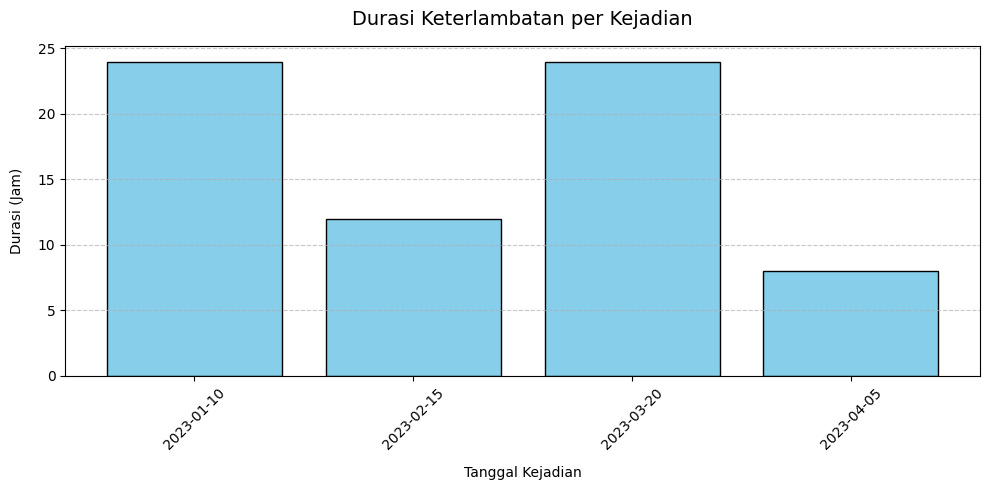

<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Data contoh (gunakan data yang sudah ada di notebook Anda)
data = {
    "tanggal": ["2023-01-10", "2023-02-15", "2023-03-20", "2023-04-05"],
    "deskripsi": [
        "Kapal delay karena badai di Laut Jawa",
        "Kerusakan mesin menyebabkan keterlambatan 12 jam",
        "Pemeriksaan bea cukai memakan waktu 24 jam",
        "Keterlambatan bongkar muat di pelabuhan"
    ],
    "durasi_jam": [24, 12, 24, 8]
}
df = pd.DataFrame(data)

# 1. Visualisasi Durasi Keterlambatan
plt.figure(figsize=(10, 5))
plt.bar(df["tanggal"], df["durasi_jam"], color='skyblue', edgecolor='black')
plt.title("Durasi Keterlambatan per Kejadian", pad=15, fontsize=14)
plt.xlabel("Tanggal Kejadian", labelpad=10)
plt.ylabel("Durasi (Jam)", labelpad=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Analisis Teks Manual (karena klasifikasi gagal)
kategori_manual = {
    "badai": "Cuaca",
    "mesin": "Teknis",
    "bea cukai": "Bea Cukai",
    "bongkar muat": "Logistik"
}

df["kategori_manual"] = df["deskripsi"].apply(
    lambda x: next((v for k, v in kategori_manual.items() if k in x.lower()), "Lainnya")
)

# Hitung frekuensi kategori
kategori_counts = df["kategori_manual"].value_counts()

plt.tight_layout()
plt.show()

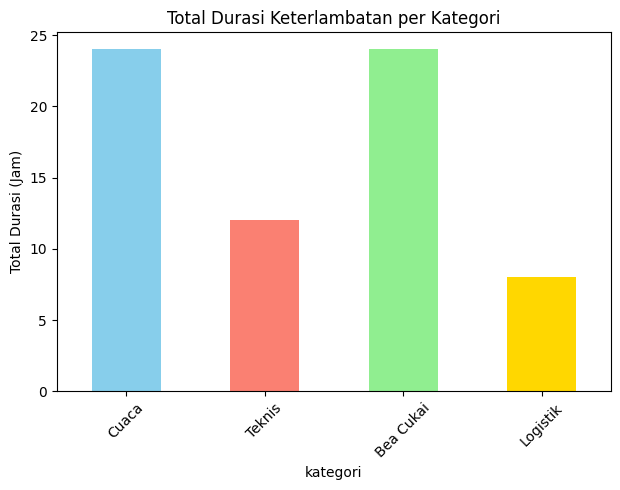

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load Data
data = {
    "tanggal": ["2023-01-10", "2023-02-15", "2023-03-20", "2023-04-05"],
    "deskripsi": [
        "Kapal delay karena badai di Laut Jawa",
        "Kerusakan mesin menyebabkan keterlambatan 12 jam",
        "Pemeriksaan bea cukai memakan waktu 24 jam",
        "Keterlambatan bongkar muat di pelabuhan"
    ],
    "durasi_jam": [24, 12, 24, 8]
}
df = pd.DataFrame(data)

# 2. Kategorisasi Manual (Rule-Based)
kategori_rules = {
    "bea cukai": "Bea Cukai",
    "bongkar muat": "Logistik",
    "badai": "Cuaca",
    "mesin": "Teknis"
}

df["kategori"] = df["deskripsi"].apply(
    lambda x: next((v for k, v in kategori_rules.items() if k in x.lower()), "Lainnya")
)

# 3. Visualisasi
plt.figure(figsize=(12, 5))

# Define the desired category order
category_order = ['Cuaca', 'Teknis', 'Bea Cukai', 'Logistik']

# Bar Chart (Subplot 1)
plt.subplot(1, 2, 1)
# Group and reindex data according to our desired order
grouped = df.groupby('kategori')['durasi_jam'].sum().reindex(category_order)
grouped.plot(
    kind='bar',
    color=['skyblue', 'salmon', 'lightgreen', 'gold'],
    title='Total Durasi Keterlambatan per Kategori'
)
plt.ylabel('Total Durasi (Jam)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

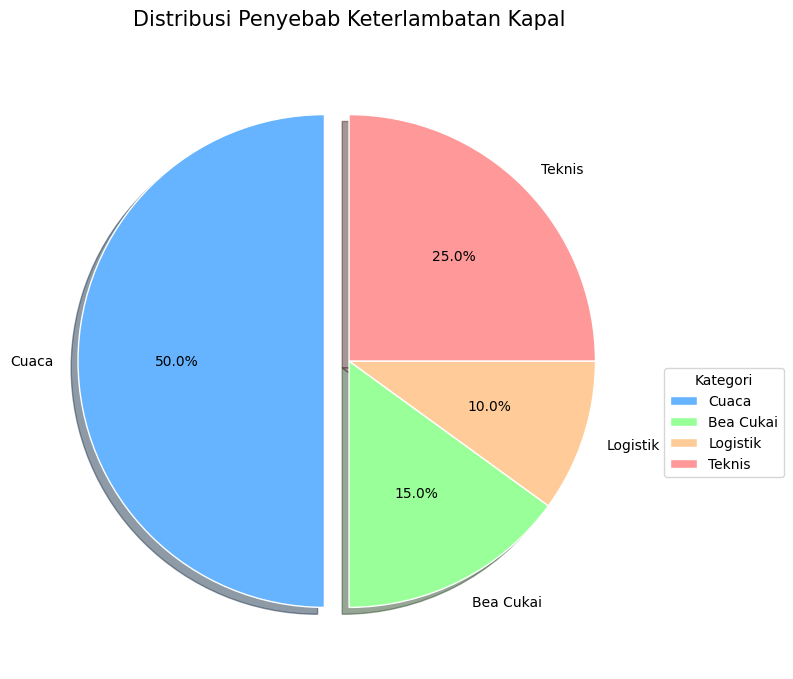

In [1]:
import matplotlib.pyplot as plt

# Data
kategori = ['Cuaca', 'Bea Cukai', 'Logistik', 'Teknis']
presentase = [50, 15, 10, 25]
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']  # Warna biru, hijau, oranye, merah

# Explode untuk menonjolkan kategori terbesar (opsional)
explode = (0.1, 0, 0, 0)  # Hanya 'Cuaca' yang sedikit menonjol

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(presentase,
        labels=kategori,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=explode,
        shadow=True,  # Efek bayangan
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'})  # Garis pembatas

# Judul dan legenda
plt.title('Distribusi Penyebab Keterlambatan Kapal', pad=20, fontsize=15)
plt.legend(kategori, title="Kategori", loc="best", bbox_to_anchor=(1, 0.5))

# Menyimpan gambar (opsional)
plt.savefig('pie_chart_keterlambatan.png', dpi=300, bbox_inches='tight')

# Menampilkan grafik
plt.tight_layout()
plt.show()